In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
df = pd.read_csv('/content/labeled_twitter_depressive_full_clean_km2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   text            123984 non-null  object 
 1   depression      123984 non-null  float64
 2   not_depression  123984 non-null  float64
 3   cluster         123984 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 3.8+ MB


In [ ]:
df = df.drop(['depression', 'not_depression'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123984 entries, 0 to 123983
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     123984 non-null  object
 1   cluster  123984 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.groupby('cluster').count()

,text
cluster,
0,70509
1,53475


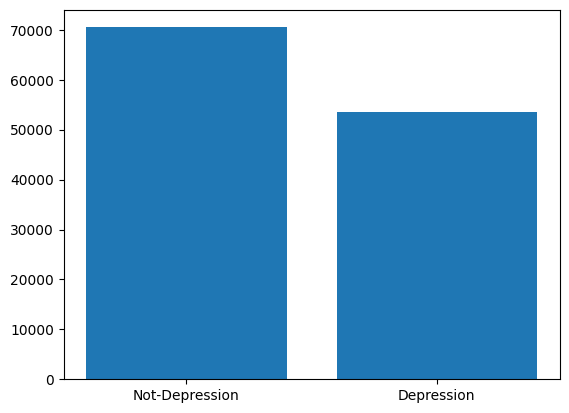

In [ ]:
classes = df.cluster.unique()
counts = []

for i in classes:
  count = len(df[df.cluster==i])
  counts.append(count)

plt.bar(['Not-Depression', 'Depression'], counts)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['cluster'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (123984,)
shape of target variable:  (123984,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')
vocab_size = len(word_index) + 1

X_train_tweets = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_tweets = pad_sequences(X_test_sequences, maxlen=max_len)

Found 77237 unique tokens.


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

oversample = SMOTE(sampling_strategy=1, random_state=42)
over_X_train, over_y_train = oversample.fit_resample(X_train_tweets, y_train)

In [ ]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(over_y_train)))

Original dataset shape Counter({0: 56407, 1: 42780})
Resampled dataset shape Counter({0: 56407, 1: 56407})


In [ ]:
print(np.count_nonzero(over_y_train == 0))
print(np.count_nonzero(over_y_train == 1))

print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

56407
56407
14102
10695


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# matthews_correlation_coefficient
def mcc_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def balanced_acc_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    sensitivity = tp / (tp + fn)
    specifity = tn / (fp + tn)
    return (sensitivity + specifity) / (2 + K.epsilon())

In [ ]:
#embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
x = transformer_block(x, True)
x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="tanh")(x)
x = Dense(8, activation="tanh")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.1))(x)

model = Model(inputs=inputs, outputs=outputs)

#model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy", metrics=['accuracy', balanced_acc_m, precision_m, recall_m, f1_m, mcc_m, keras.metrics.AUC()])
checkpoint = ModelCheckpoint("best_epoch_transformer_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(over_X_train, over_y_train, batch_size=64, epochs=50, validation_data=(X_test_tweets, y_test), callbacks=[checkpoint, stop_early])
#model.save('model_transformer_save.keras')

Epoch 1/50
1763/1763 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.6797 - balanced_acc_m: 0.6795 - precision_m: 0.6956 - recall_m: 0.6502 - f1_m: 0.6551 - mcc_m: 0.3647 - auc: 0.7625
Epoch 1: val_accuracy improved from -inf to 0.80159, saving model to best_epoch_transformer_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1763/1763 [==============================] - 71s 35ms/step - loss: 0.6651 - accuracy: 0.6797 - balanced_acc_m: 0.6795 - precision_m: 0.6956 - recall_m: 0.6502 - f1_m: 0.6551 - mcc_m: 0.3647 - auc: 0.7625 - val_loss: 0.5150 - val_accuracy: 0.8016 - val_balanced_acc_m: 0.8021 - val_precision_m: 0.7534 - val_recall_m: 0.8044 - val_f1_m: 0.7750 - val_mcc_m: 0.5998 - val_auc: 0.8813
Epoch 2/50
1762/1763 [============================>.] - ETA: 0s - loss: 0.5166 - accuracy: 0.7935 - balanced_acc_m: 0.7937 - precision_m: 0.7954 - recall_m: 0.7918 - f1_m: 0.7902 - mcc_m: 0.5880 - auc: 0.8660
Epoch 2: val_accuracy improved from 0.80159 to 0.81232, saving model to best_epoch_transformer_model.h5
1763/1763 [==============================] - 46s 26ms/step - loss: 0.5166 - accuracy: 0.7936 - balanced_acc_m: 0.7938 - precision_m: 0.7954 - recall_m: 0.7918 - f1_m: 0.7903 - mcc_m: 0.5881 - auc: 0.8661 - val_loss: 0.4820 - val_accuracy: 0.8123 - val_balanced_acc_m: 0.8117 - val_precision_m: 0.7690 - val

In [ ]:
y_predict_transformer = model.evaluate(X_test_tweets, y_test, verbose=0)
y_predict_transformer

[0.49586841464042664,
 0.7951768636703491,
 0.7918601036071777,
 0.7603371739387512,
 0.7685760259628296,
 0.7571247816085815,
 0.5829417109489441,
 0.8705737590789795]

(0.0, 0.676377671957016)

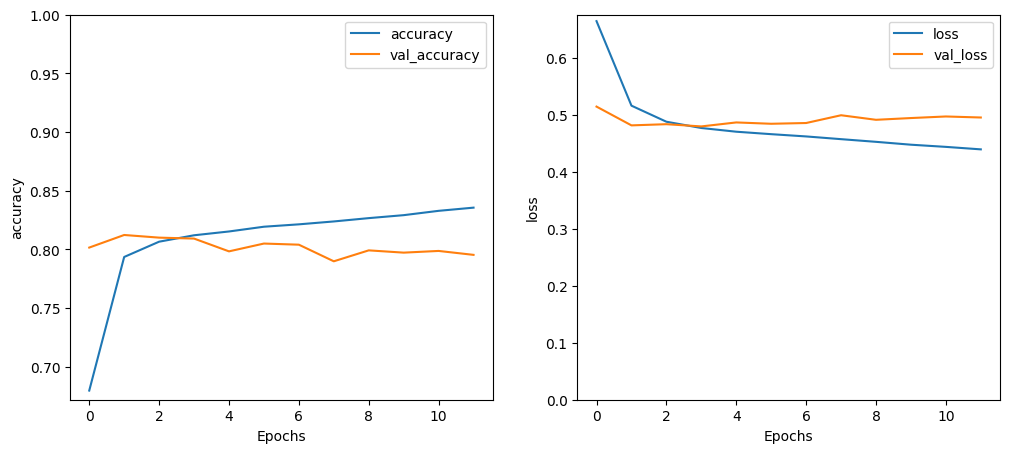

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
history.history

{'loss': [0.6651138067245483,
  0.5166195034980774,
  0.48838675022125244,
  0.477369487285614,
  0.47084441781044006,
  0.4665277898311615,
  0.46255266666412354,
  0.45775818824768066,
  0.45306679606437683,
  0.4480271339416504,
  0.4442049562931061,
  0.4398365020751953],
 'accuracy': [0.6797383427619934,
  0.7935805916786194,
  0.8066020011901855,
  0.8120712041854858,
  0.8153066039085388,
  0.8193575143814087,
  0.8213874101638794,
  0.8238516449928284,
  0.8266792893409729,
  0.8292055726051331,
  0.8328930735588074,
  0.8356143832206726],
 'balanced_acc_m': [0.6795074343681335,
  0.7937562465667725,
  0.8065527081489563,
  0.8117787837982178,
  0.8156655430793762,
  0.8192532062530518,
  0.8215694427490234,
  0.8239912986755371,
  0.8264655470848083,
  0.8294216394424438,
  0.8328074812889099,
  0.8356494903564453],
 'precision_m': [0.6955737471580505,
  0.7954301834106445,
  0.8076237440109253,
  0.8124842047691345,
  0.8143540620803833,
  0.8165040016174316,
  0.819528818130

In [ ]:
import json

results_transformer = json.dumps(history.history)

with open('results_transf_full_clean_smote-train_depressive.json', 'w') as archivo:
    archivo.write(results_transformer)

# Load the Transformer Model

In [ ]:
metric_list = {"recall_m": recall_m, "precision_m": precision_m, "f1_m": f1_m,
               "mcc_m": mcc_m, "balanced_acc_m": balanced_acc_m, "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
               "TransformerBlock": TransformerBlock}

load_transf_model = tf.keras.models.load_model('/content/best_epoch_transformer_model.h5', custom_objects=metric_list)

In [ ]:
y_predict_transf_load = load_transf_model.evaluate(X_test_tweets, y_test, verbose=0)
y_predict_transf_load

[0.4819556176662445,
 0.8121547102928162,
 0.8113676309585571,
 0.7695522904396057,
 0.8064761757850647,
 0.7814543843269348,
 0.6193292140960693,
 0.8863624334335327]